# Information Leakage

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [2]:
rnd= np.random.RandomState(seed=2020)
x=rnd.normal(size=(100,10000))
y=rnd.normal(size=(100,))

Harusnya tidak ada hubungan antara x dan y karena data dibuat secara random

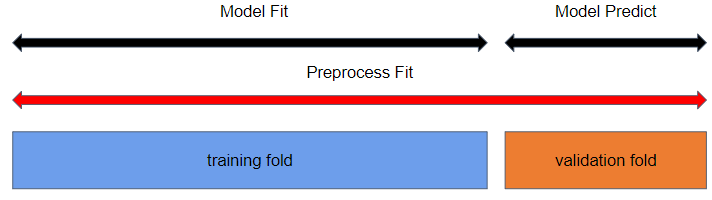

In [3]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [5]:
select= SelectPercentile(score_func=f_regression, percentile=5).fit(x,y)
x_selected=select.transform(x)
x_selected.shape

(100, 500)

In [8]:
cross_val_score(Ridge(),x_selected,y,cv=5)

array([0.92165345, 0.89445668, 0.92827414, 0.93088559, 0.91044624])

Hasil cross validasi mengindikasikan model dengan prediksi yang sangat baik, walaupum data yang dipakai random dan seharusnya tidak ada hubungan.

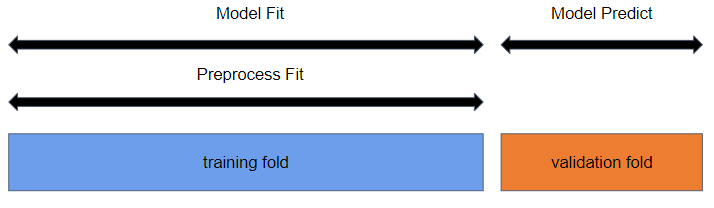

In [10]:
from sklearn.pipeline import Pipeline

In [12]:
select= SelectPercentile(score_func=f_regression, percentile=5)

pipe= Pipeline([('select', select),
              ('ridge',Ridge())])

In [13]:
cross_val_score(pipe,x,y,cv=5)

array([-0.0330359 , -0.07840338, -0.06731106, -0.04544685, -0.07314928])

ini adalah nilai r-squared yang seharusnya kita dapat, sangat rendah dan bahkan negatif. Information leakage menyebabkan model memberikan hasil yang terlalu optimis ketika kita melakukan validasi.

# Algorithm Chain: Adult Dataset

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline

## Data

In [15]:
df=pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [17]:
df.replace('?',np.nan).isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## Preprocessing
y= income  
x= drop fnlwgt  

skema=  
* one hot: relationship, race, sex  
* simple imputer (constan),binary: workclass, marital.status, occupation
* ordinal: education (sudah dibuat)


In [18]:
binary_pipe= Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NC', missing_values='?')),
    ('binary encoder', ce.BinaryEncoder())
])

In [31]:
transformer=ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'),['relationship', 'race','sex']),
    ('binary', binary_pipe,['workclass','marital.status','occupation', 'native.country'])
], remainder='passthrough')

In [32]:
transformer.fit_transform(df) #coba transformer

array([[1.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       [1.0, 0.0, 0.0, ..., 4356, 18, '<=50K'],
       [0.0, 0.0, 0.0, ..., 4356, 40, '<=50K'],
       ...,
       [0.0, 0.0, 0.0, ..., 0, 40, '>50K'],
       [0.0, 0.0, 0.0, ..., 0, 40, '<=50K'],
       [0.0, 0.0, 1.0, ..., 0, 20, '<=50K']], dtype=object)

## Splitting data

In [33]:
x= df.drop(columns=['fnlwgt','income','education'])
y= np.where(df['income']=='>50K',1,0)

In [34]:
x_train, x_test, y_train, y_test= train_test_split(x,y,
                                                  stratify=y,
                                                  random_state=2020)

## Benchmark

In [35]:
tree= DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2020)
pipe_tree=Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])

In [37]:
model_cv=cross_val_score(pipe_tree, x_train, y_train, scoring='f1')

In [38]:
print(model_cv)
print(model_cv.mean())
print(model_cv.std())

[0.59255482 0.60502513 0.59898477 0.62110553 0.6221336 ]
0.6079607686024484
0.011833711368265581


In [39]:
tree=DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=2020)
logreg=LogisticRegression(solver='liblinear', random_state=2020)

In [41]:
models=[tree,logreg]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess', transformer),
        ('model', i)
    ])
    model_cv=cross_val_score(estimator, x_train, y_train, cv=skfold, scoring='f1')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

In [42]:
pd.DataFrame({
    'model':['tree','logreg'],
    'score':score,
    'mean':rata,
    'std':std
})

,model,score,mean,std
0,tree,"[0.5925548189699132, 0.6050251256281407, 0.598...",0.607961,0.011834
1,logreg,"[0.6065654091131798, 0.6644674835061263, 0.633...",0.642688,0.021901


Dari hasil cross validasi log regresi memiliki performa rata-ratata yg lebih baik walau sedikit lebih tidak stabil. Kita akan lanjut dengan mengoptimasi model logistik regresi.

### Model Performance with Data Test

In [45]:
logreg=LogisticRegression(solver='liblinear', random_state=2020)
estimator= Pipeline([
    ('preprocess',transformer),
    ('model',logreg)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                      

In [46]:
y_pred= estimator.predict(x_test)

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.59      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



## Hyperparameter Tunning

In [49]:
logreg=LogisticRegression(solver='liblinear', random_state=2020)
estimator= Pipeline([
    ('preprocess',transformer),
    ('model',logreg)
])

In [50]:
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('one hot', OneHotEncoder(drop='first'),
                                    ['relationship', 'race', 'sex']),
                                   ('binary',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='NC',
                                                                   missing_values='?',
                                                                   strategy='constant')),
                                                    ('binary encoder',
                                                     BinaryEncoder())]),
                                    ['workclass', 'marital.status', 'occupation',
                                     'native.country'])])),
  ('model', LogisticRegression(random_state=2020, solver='liblinear'))],
 'verbose': False,
 'preprocess': C

In [51]:
hyperparam_space={'model__C':[100,10,1,0.1,0.001],
                 'model__solver':['liblinear','newton-cg']}

In [52]:
skfold=StratifiedKFold(n_splits=5)
grid_search= GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)

In [53]:
grid_search.fit(x_train,y_train)

C:\Users\brigi\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\brigi\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary',
                                                                         Pipeline(steps=[('imputer',
                                                                                   

In [54]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.6460237640462658
{'model__C': 100, 'model__solver': 'newton-cg'}


In [55]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.845017,0.343302,0.158735,0.024392,100,liblinear,"{'model__C': 100, 'model__solver': 'liblinear'}",0.606654,0.660085,0.632089,0.642185,0.665728,0.641348,0.021145,7
1,29.959248,3.449585,0.118819,0.008177,100,newton-cg,"{'model__C': 100, 'model__solver': 'newton-cg'}",0.625773,0.665730,0.628846,0.642790,0.666980,0.646024,0.017568,1
2,3.196954,0.256466,0.135568,0.025672,10,liblinear,"{'model__C': 10, 'model__solver': 'liblinear'}",0.618005,0.661343,0.631120,0.640535,0.665728,0.643346,0.018024,5
3,23.613035,2.824243,0.129356,0.016733,10,newton-cg,"{'model__C': 10, 'model__solver': 'newton-cg'}",0.625119,0.665730,0.628846,0.643093,0.666980,0.645954,0.017710,2
4,3.321274,0.255058,0.121584,0.017714,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.606565,0.664467,0.633317,0.643363,0.665728,0.642688,0.021901,6
5,15.689485,0.873849,0.116670,0.011056,1,newton-cg,"{'model__C': 1, 'model__solver': 'newton-cg'}",0.624762,0.664477,0.627526,0.642756,0.666353,0.645175,0.017636,3
6,2.950515,0.241896,0.128013,0.021594,0.1,liblinear,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.601779,0.646301,0.629720,0.637363,0.644068,0.631846,0.016108,8
7,12.517780,0.553121,0.070782,0.033335,0.1,newton-cg,"{'model__C': 0.1, 'model__solver': 'newton-cg'}",0.622778,0.661633,0.623188,0.644550,0.664775,0.643385,0.018025,4
8,2.540780,0.141994,0.133338,0.022593,0.001,liblinear,"{'model__C': 0.001, 'model__solver': 'liblinear'}",0.431373,0.448276,0.392405,0.431108,0.439601,0.428553,0.019143,10
9,7.970427,1.109113,0.037765,0.014959,0.001,newton-cg,"{'model__C': 0.001, 'model__solver': 'newton-cg'}",0.557794,0.559358,0.536559,0.569910,0.572038,0.559132,0.012603,9


## Before vs After Tunning

In [58]:
logreg=LogisticRegression(solver='liblinear', random_state=2020)
estimator=Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])
estimator.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                      

In [60]:
y_pred= estimator.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.59      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [62]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.6528878822197056

In [63]:
best_model=grid_search.best_estimator_
best_model.fit(x_train,y_train)

C:\Users\brigi\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\brigi\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 missing_values='?',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                      

In [64]:
y_pred=best_model.predict(x_test)

In [65]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6181
           1       0.73      0.60      0.66      1960

    accuracy                           0.85      8141
   macro avg       0.80      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [66]:
f1_score(y_test,y_pred)

0.6567749160134378

performa model naik sedikit dari f1 score 65.3% menjadi 65.6% setelah tunning

# Latihan

Dengan menggunakan data titanic:
    * carilah model dan parameter terbaik untuk memprediksi apakah seseorang selamat atau tidak.
    * konteks: memprediksi kemungkinan seseorang selamat jika kapal yang **akan** dinaikinya karam
    * model yang dicoba:
        * logistic regression, decision tree classifier, KNclassifier
    * Pilih 1 model terbaik dari hasil cross validasinya, lalu tunning model tersebut
    
Kumpulkan ke Brigita.gems@gmail.com dengan subject: algoritmn chain